This vignette demonstrates simple regression of SIF with covariates using the spatial sampling technique from the previous notebook.
Results are summarized for all averaging windows for all ecoregions

First, we will load the necessary packages to run the code

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#
# Author: Lewis Kunik - University of Utah
# Contact: lewis.kunik@utah.edu
#

#%%
#########################################
# Load packages
#########################################

# File system packages
import os  # operating system library
import sys
import glob
from pathlib import Path
import copy

# numerical/data management packages
import numpy as np
import xarray as xr 
import pandas as pd

# shapefile/geospatial packages
import geopandas as gpd
from shapely.geometry import mapping
from shapely.geometry import Point

# Stats packages
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# time and date packages
import time
from datetime import datetime as dt  # date time library
from datetime import timedelta

# Standard plotting packages
from matplotlib import pyplot as plt  # primary plotting module
from matplotlib.ticker import FuncFormatter as FFmt  # need this for formatting plot ticks

# Geospatial plotting packages
import cartopy.crs as ccrs  # cartopy is the best spatial plotting library i know
from cartopy.io import img_tiles  # cartopy's implementation of webtiles
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature




Define any global filepaths and variables that will be needed throughout the script 

In [2]:

#########################################
# Define Global Filepaths
#########################################

dat_basedir = '/uufs/chpc.utah.edu/common/home/lin-group19/ltk/SIF/SIF_IAV/data/'
dat_dir_precip = '/uufs/chpc.utah.edu/common/home/lin-group19/ltk/SIF/SIF_IAV/data/TOT_WY_Precip'
EPA_ecoregion_dir = '/uufs/chpc.utah.edu/common/home/lin-group23/ltk/EPA/ecoregions/'
EPA_ecoregion_L2_file = os.path.join(EPA_ecoregion_dir, 'L2', 'WUS_cec_eco_l2.shp')

########################################
# Define Global Variables and constants
#########################################

#########################################
# Set plotting parameters
#########################################

plt.rcParams.update({
   'axes.labelsize': 16,
   'axes.titlesize': 16,
   'xtick.labelsize': 16,
   'ytick.labelsize': 15,
   'legend.fontsize': 13,
})

# use Google Satellite imagery as basemap
tiler = img_tiles.GoogleTiles(style='satellite')
crs = tiler.crs # set crs of map tiler
alpha = 0.8  # transparency 0-1
transform = ccrs.PlateCarree()  # transform specifies the crs that the data is in

tiler_zoom = 7  # define a zoom level of detail
extent = [-125.3, -102.7, 29.7, 50.3]  # [minx, maxx, miny, maxy], bounds for map

### Load state boundaries
fn = shpreader.natural_earth(
   resolution='10m', category='cultural', 
   name='admin_1_states_provinces',
)
reader = shpreader.Reader(fn)
states = [x for x in reader.records() if x.attributes["admin"] == "United States of America"] # get all states in US
states_geom = cfeature.ShapelyFeature([x.geometry for x in states], ccrs.PlateCarree())

# matplotlib map plotting functions
def z_axis_formatter(x, pos, deci=2):
   '''Format ticks to format with deci number of decimals'''

   return f'{x:.{deci}f}'



### Set specific global variables relevant to the analysis

In [ ]:
num_reps = 100 # Set this higher for final analysis

Define any functions that will be needed throughout the script

In [4]:
#########################################
# Define Global Functions
#########################################

# -----------------------------------------------------------------------
# Function to load xarray data and set CRS
# -----------------------------------------------------------------------
def load_xr(dat_xr_file, varname = None):
    if varname is not None:
        dat_xr = xr.open_dataset(dat_xr_file, decode_coords='all').sortby(['x', 'y'], ascending = True)[varname]
    else:
        dat_xr = xr.open_dataset(dat_xr_file, decode_coords='all').sortby(['x', 'y'], ascending = True)
    dat_xr.rio.write_crs(4326, inplace=True)
    return dat_xr



def xarray_to_long_df(da_dict, response_var_name):
    """
    Convert dictionary of xarray DataArrays to long format DataFrame
    suitable for mixed effects modeling
    """
    # Start with response variable - only keep essential coordinates
    response_da = da_dict[response_var_name]
    df = response_da.to_dataframe(name=response_var_name).reset_index()
    
    # Keep only the columns we need for merging and analysis
    essential_cols = ['x', 'y', response_var_name]
    if 'year' in df.columns:
        essential_cols.append('year')
    
    df = df[essential_cols].dropna(subset=[response_var_name])
    
    # Add explanatory variables one by one
    for var_name, da in da_dict.items():
        if var_name != response_var_name:
            # Convert to dataframe and keep only essential columns
            var_df = da.to_dataframe(name=var_name).reset_index()
            
            # Keep only coordinates and the variable of interest
            var_essential_cols = ['x', 'y', var_name]
            if 'year' in var_df.columns:
                var_essential_cols.append('year')
            
            var_df = var_df[var_essential_cols].dropna(subset=[var_name])
            
            # Handle time-invariant variables (no year dimension)
            if 'year' not in var_df.columns and 'year' in df.columns:
                # Replicate time-invariant data for each year
                years = df['year'].unique()
                var_df_expanded = []
                for year in years:
                    temp_df = var_df.copy()
                    temp_df['year'] = year
                    var_df_expanded.append(temp_df)
                var_df = pd.concat(var_df_expanded, ignore_index=True)
            
            # Determine merge columns
            merge_cols = ['x', 'y']
            if 'year' in var_df.columns:
                merge_cols.append('year')
                
            # Merge with main dataframe
            df = df.merge(var_df, on=merge_cols, how='inner')
    
    return df



def spatial_subsample_grid_probabilistic(df, spacing_deg=1.0, seed=None, verbose=False):
    """
    Subsample pixels by dividing domain into regular grid cells, then:
    1. Count valid pixels in each cell
    2. Sample one random pixel from each cell
    3. Include sampled pixel with probability proportional to cell density
    
    Cells with the most pixels have probability=1.0 (always included)
    Cells with fewer pixels have proportionally lower probability
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame with 'x' (longitude) and 'y' (latitude) columns
    spacing_deg : float
        Grid cell size in degrees (e.g., 1.0 for 1° x 1° cells)
    seed : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    DataFrame with probabilistically subsampled pixels
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Get unique pixel locations
    pixels = df[['pixel_id', 'x', 'y']].drop_duplicates()
    
    # Get domain extent
    x_min, x_max = pixels['x'].min(), pixels['x'].max()
    y_min, y_max = pixels['y'].min(), pixels['y'].max()
    
    # Create grid cell boundaries
    x_bins = np.arange(x_min, x_max + spacing_deg, spacing_deg)
    y_bins = np.arange(y_min, y_max + spacing_deg, spacing_deg)
    
    if verbose:
        print(f"Grid dimensions: {len(x_bins)-1} x {len(y_bins)-1} = {(len(x_bins)-1) * (len(y_bins)-1)} cells")

    # Assign each pixel to a grid cell
    pixels['x_cell'] = np.digitize(pixels['x'], x_bins) - 1
    pixels['y_cell'] = np.digitize(pixels['y'], y_bins) - 1
    pixels['cell_id'] = pixels['x_cell'].astype(str) + '_' + pixels['y_cell'].astype(str)
    
    # Count pixels per cell
    cell_counts = pixels.groupby('cell_id').size()
    max_count = cell_counts.max()
    if verbose:
        print(f"Pixels per cell - Min: {cell_counts.min()}, Max: {max_count}, Mean: {cell_counts.mean():.1f}")
    
    # Calculate probability for each cell (proportional to pixel count)
    cell_probabilities = cell_counts / max_count
    
    selected_pixels = []
    cell_info = []
    
    # For each cell, randomly sample one pixel and decide whether to include it
    for cell_id, cell_group in pixels.groupby('cell_id'):
        n_pixels_in_cell = len(cell_group)
        probability = cell_probabilities[cell_id]
        
        # Randomly select one pixel from this cell
        sampled_pixel = cell_group.sample(n=1, random_state=seed).iloc[0]
        
        # Include this pixel with probability proportional to cell density
        if np.random.random() < probability:
            selected_pixels.append(sampled_pixel['pixel_id'])
            cell_info.append({
                'cell_id': cell_id,
                'n_pixels': n_pixels_in_cell,
                'probability': probability,
                'included': True
            })
        else:
            cell_info.append({
                'cell_id': cell_id,
                'n_pixels': n_pixels_in_cell,
                'probability': probability,
                'included': False
            })
    
    # Create summary dataframe
    cell_summary = pd.DataFrame(cell_info)
    if verbose:
        print(f"\nOriginal pixels: {len(pixels)}")
        print(f"Grid cells with data: {len(cell_counts)}")
        print(f"Cells included in sample: {cell_summary['included'].sum()}")
        print(f"Final subsampled pixels: {len(selected_pixels)}")
        print(f"Reduction: {100 * (1 - len(selected_pixels)/len(pixels)):.1f}%")
        
        # Print probability distribution
        print(f"\nProbability distribution:")
        print(f"  Cells with p=1.0 (max density): {(cell_probabilities == 1.0).sum()}")
        print(f"  Cells with p>=0.75: {(cell_probabilities >= 0.75).sum()}")
        print(f"  Cells with p>=0.50: {(cell_probabilities >= 0.50).sum()}")
        print(f"  Cells with p>=0.25: {(cell_probabilities >= 0.25).sum()}")
        print(f"  Cells with p<0.25: {(cell_probabilities < 0.25).sum()}")
        
    # Filter original dataframe to keep only selected pixels
    df_subsampled = df[df['pixel_id'].isin(selected_pixels)].copy()
    
    # Optionally return cell summary for diagnostics
    df_subsampled.attrs['cell_summary'] = cell_summary
    df_subsampled.attrs['cell_probabilities'] = cell_probabilities
    
    return df_subsampled




### Load in ecoregion data

In [6]:

# Load EPA L2 Ecoregion file and define individual region geometries
ecoregion_l2_gdf = gpd.read_file(EPA_ecoregion_L2_file)

print("Unique ecoregion names:")
print(ecoregion_l2_gdf.NA_L2NAME.unique())
Region1_name = 'MARINE WEST COAST FOREST'
Region2_name = 'WESTERN CORDILLERA'
Region3_name = 'UPPER GILA MOUNTAINS'
ecoregion_l2_gdf_Region1 = ecoregion_l2_gdf[ecoregion_l2_gdf.NA_L2NAME == Region1_name]
ecoregion_l3_geom_Region1 = ecoregion_l2_gdf_Region1.geometry

ecoregion_l2_gdf_Region2 = ecoregion_l2_gdf[ecoregion_l2_gdf.NA_L2NAME == Region2_name]
ecoregion_l3_geom_Region2 = ecoregion_l2_gdf_Region2.geometry

ecoregion_l2_gdf_Region3 = ecoregion_l2_gdf[ecoregion_l2_gdf.NA_L2NAME == Region3_name]
ecoregion_l3_geom_Region3 = ecoregion_l2_gdf_Region3.geometry


region_names = ['Southwest', 'West', 'Marine']

# List of region geometries and names
region_geoms = [
    ecoregion_l3_geom_Region3, ecoregion_l3_geom_Region2, ecoregion_l3_geom_Region1
]

### Define minimum sampling distances for each ecoregion group based on spatial autocorrelation analysis
min_dists = [0.5, 1.5, 0.5] ## in deg; From previous jupyter notebook

Unique ecoregion names:
['COLD DESERTS' 'WARM DESERTS' 'MEDITERRANEAN CALIFORNIA'
 'WESTERN SIERRA MADRE PIEDMONT' 'UPPER GILA MOUNTAINS'
 'WESTERN SIERRA MADRE' 'WESTERN PACIFIC COASTAL PLAIN, HILLS AND CANYONS'
 'WESTERN CORDILLERA' 'MARINE WEST COAST FOREST' 'TEMPERATE PRAIRIES'
 'WEST-CENTRAL SEMIARID PRAIRIES' 'SOUTH CENTRAL SEMIARID PRAIRIES'
 'TAMAULIPAS-TEXAS SEMIARID PLAIN']


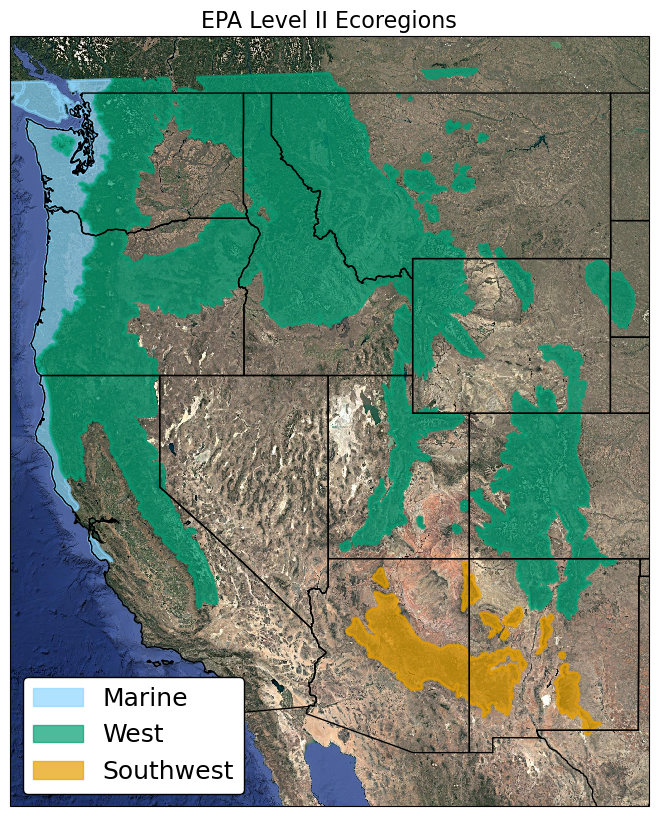

In [7]:
#### Plot a map of ecoregions
figsize = (12, 10)  # width, height in inches
fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize=figsize)

# Set extent of map before adding base img
ax.set_extent(extent, crs=ccrs.PlateCarree())  # PlateCarree is default lat/lon
ax.add_image(tiler, tiler_zoom, interpolation='none', alpha=1) # Add base image

alpha = 0.75  # transparency 0-1

# Plot numbered text boxes at centroids of each region
import matplotlib.patches as mpatches
ax.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)
ax.add_geometries(ecoregion_l3_geom_Region1, crs=transform, facecolor="#8ED6FF", edgecolor='#8ED6FF', linewidth=2, zorder=1, alpha = 0.7)
ax.add_geometries(ecoregion_l3_geom_Region2, crs=transform, facecolor="#009E73", edgecolor='#009E73', linewidth=2, zorder=1, alpha = 0.7)
ax.add_geometries(ecoregion_l3_geom_Region3, crs=transform, facecolor="#E69F00", edgecolor='#E69F00', linewidth=2, zorder=1, alpha = 0.7)

# Create custom legend patches
legend_patches = [
    mpatches.Patch(facecolor="#8ED6FF", edgecolor='#8ED6FF', alpha=0.7, label='Marine'),
    mpatches.Patch(facecolor="#009E73", edgecolor='#009E73', alpha=0.7, label='West'),
    mpatches.Patch(facecolor="#E69F00", edgecolor='#E69F00', alpha=0.7, label='Southwest'),
]

plt.xlabel('lon', fontsize=10)
plt.ylabel('lat', fontsize=10)
plt.title('EPA Level II Ecoregions') # set axis title
ax.legend(handles=legend_patches, loc='lower left', fontsize=18, frameon=True, facecolor='white', edgecolor='black', framealpha=1)
plt.show()

In [8]:
### Define a function to plot the ecoregions, highlighting the current region

def plot_ecoregion_map(region_name, region_geom):

    #### Plot a map of ecoregions
    figsize = (8, 7)  # width, height in inches
    fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize=figsize)

    # Set extent of map before adding base img
    ax.set_extent(extent, crs=ccrs.PlateCarree())  # PlateCarree is default lat/lon
    ax.add_image(tiler, 5, interpolation='none', alpha=0.6) # Add base image

    alpha = 0.75  # transparency 0-1

    # Plot numbered text boxes at centroids of each region
    import matplotlib.patches as mpatches
    ax.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)
    ax.add_geometries(region_geom, crs=transform, facecolor="white", edgecolor='none', linewidth=1, zorder=1, alpha = 0.7)
    ax.add_geometries(ecoregion_l3_geom_Region1, crs=transform, facecolor="none", edgecolor='#8ED6FF', linewidth=2, zorder=1, alpha = 0.7)
    ax.add_geometries(ecoregion_l3_geom_Region2, crs=transform, facecolor="none", edgecolor='#009E73', linewidth=2, zorder=1, alpha = 0.7)
    ax.add_geometries(ecoregion_l3_geom_Region3, crs=transform, facecolor="none", edgecolor='#E69F00', linewidth=2, zorder=1, alpha = 0.7)
    plt.xlabel('lon', fontsize=10)
    plt.ylabel('lat', fontsize=10)
    plt.title(f'Region: {region_name}') # set axis title
    plt.show()

### Simple regression analysis with stochastic sampling

The simple regression analysis will take the form of this equation:

$$y = \beta_0 + \beta_1 x + \epsilon$$

where:
- $y$ is the response variable (SIF)
- $\beta_0$ is the modeled intercept
- $\beta_1$ is the modeled slope
- $x$ is the predictor variable (e.g. NDVI)
- $\epsilon$ is the residual error

Below is a step-through example of how the data are used in the modeling:

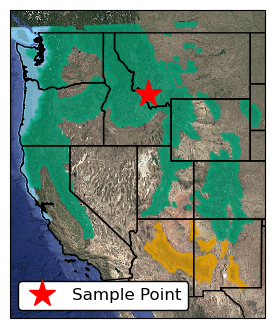

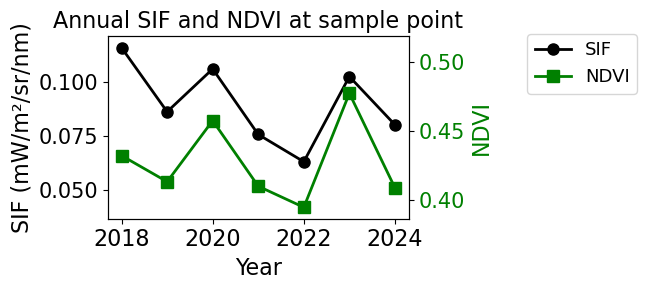

In [ ]:
covariate_name = 'NDVI'

### Sample year of data from a sample pixel
sample_timing_dir = os.path.join(dat_basedir, 'FULL_YEAR')  # directory where data files are stored, based on timing_label
TROPOMI_SIF_file = glob.glob(f'{sample_timing_dir}/TROPOMI_SIF*.nc')[0]
TROPOMI_SIF_xr = load_xr(TROPOMI_SIF_file, 'sifdc') # TROPOMI SIF
covariate_file = glob.glob(f'{sample_timing_dir}/MODIS_MOD13A2_NDVI*.nc')[0]
covariate_xr = load_xr(covariate_file, 'NDVI') # MODIS NDVI

valid_data = TROPOMI_SIF_xr.where(TROPOMI_SIF_xr.notnull(), drop=True)
valid_coords = valid_data.stack(z=('x', 'y')).dropna(dim='z', how='all')

sample_lon = -113.075
sample_lat = 45.325

#### Plot a map of ecoregions
figsize = (4, 4)  # width, height in inches
fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize=figsize)

# Set extent of map before adding base img
ax.set_extent(extent, crs=ccrs.PlateCarree())  # PlateCarree is default lat/lon
ax.add_image(tiler, 5, interpolation='none', alpha=1) # Add base image

alpha = 0.75  # transparency 0-1

# Plot numbered text boxes at centroids of each region
import matplotlib.patches as mpatches
ax.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)
# for geom_region in region_geoms_Pacific_group:
ax.add_geometries(ecoregion_l3_geom_Region1, crs=transform, facecolor="#8ED6FF", edgecolor='#8ED6FF', linewidth=2, zorder=1, alpha = 0.7)
ax.add_geometries(ecoregion_l3_geom_Region2, crs=transform, facecolor="#009E73", edgecolor='#009E73', linewidth=2, zorder=1, alpha = 0.7)
ax.add_geometries(ecoregion_l3_geom_Region3, crs=transform, facecolor="#E69F00", edgecolor='#E69F00', linewidth=2, zorder=1, alpha = 0.7)

# Plot the sample point
ax.plot(sample_lon, sample_lat, 'r*', markersize=20, transform=transform, zorder=10, label='Sample Point')
plt.legend(loc='lower left', fontsize=12, frameon=True, facecolor='white', edgecolor='black', framealpha=1)
plt.show()

# Extract values at sample location
sif_at_point = TROPOMI_SIF_xr.sel(x=sample_lon, y=sample_lat, method='nearest')
covariate_at_point = covariate_xr.sel(x=sample_lon, y=sample_lat, method='nearest')

# Create figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(5, 3))
# Calculate axis limits with 10% offset
sif_range = np.nanmax(sif_at_point.values) - np.nanmin(sif_at_point.values)
sif_offset = 0.5 * sif_range
sif_ymin = np.nanmin(sif_at_point.values) - sif_offset
sif_ymax = np.nanmax(sif_at_point.values) + (sif_offset*0.2)

covariate_range = np.nanmax(covariate_at_point.values) - np.nanmin(covariate_at_point.values)
covariate_offset = 0.5 * covariate_range
covariate_ymin = np.nanmin(covariate_at_point.values) - (covariate_offset*0.2)
covariate_ymax = np.nanmax(covariate_at_point.values) + covariate_offset

# Plot SIF on left y-axis
ax1.plot(sif_at_point['year'], sif_at_point.values, 
         color='black', marker='o', linewidth=2, markersize=8, label='SIF')
ax1.set_xlabel('Year')
ax1.set_ylabel('SIF (mW/m²/sr/nm)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(sif_ymin, sif_ymax)

# Create second y-axis for covariate
ax2 = ax1.twinx()
ax2.plot(covariate_at_point['year'], covariate_at_point.values, 
         color='green', marker='s', linewidth=2, markersize=8, label=covariate_name)
ax2.set_ylabel(covariate_name, color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylim(covariate_ymin, covariate_ymax)

# Add title and legend
plt.title(f'Annual SIF and {covariate_name} at sample point')
fig.legend(loc='upper left', bbox_to_anchor=(1.02, 0.9))
plt.tight_layout()
plt.show()




Those are the annual values of SIF and the covariate at the sample point. Now we standardize the covariate to a z-score (i.e. the number of standard deviations away from the region mean).

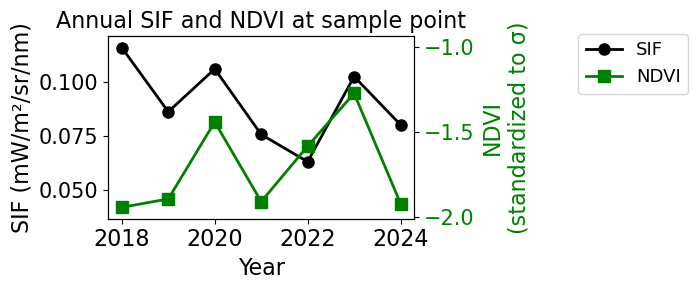

In [ ]:


##############################
## Prep data for model fitting, including standardization
##############################
region_geom = ecoregion_l3_geom_Region2
xr_data_dict = {
    'SIF': TROPOMI_SIF_xr.rio.clip(region_geom.geometry, drop=True),
    covariate_name: covariate_xr.rio.clip(region_geom.geometry, drop=True),
}

df_long = xarray_to_long_df(xr_data_dict, 'SIF')
key_vars = ['SIF', covariate_name]

# Add pixel_id, longitude, latitude
df_long['pixel_id'] = df_long['x'].astype(str) + '_' + df_long['y'].astype(str)
df_long['longitude'] = df_long['x']
df_long['latitude'] = df_long['y']

# Clean up - remove rows with missing values in key variables
df_model = df_long.dropna(subset=key_vars).copy()

# Standardize predictors
all_predictors = [covariate_name]
df_standardized = df_model.copy()
df_standardized[all_predictors] = StandardScaler().fit_transform(df_model[all_predictors])

# Get covariate values for all years at sample location from df_standardized
covariate_at_sample = df_standardized[
    (df_standardized['x'] == sample_lon) & 
    (df_standardized['y'] == sample_lat)
][['year', covariate_name]].sort_values('year')


covariate_range = np.nanmax(covariate_at_sample[covariate_name].values) - np.nanmin(covariate_at_sample[covariate_name].values)
covariate_offset = 0.5 * covariate_range
covariate_ymin = np.nanmin(covariate_at_sample[covariate_name].values) - (covariate_offset*0.2)
covariate_ymax = np.nanmax(covariate_at_sample[covariate_name].values) + covariate_offset

# Plot SIF on left y-axis
fig, ax1 = plt.subplots(figsize=(5.5, 3))
ax1.plot(sif_at_point['year'], sif_at_point.values, 
         color='black', marker='o', linewidth=2, markersize=8, label='SIF')
ax1.set_xlabel('Year')
ax1.set_ylabel('SIF (mW/m²/sr/nm)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(sif_ymin, sif_ymax)

# Create second y-axis for covariate
ax2 = ax1.twinx()
ax2.plot(covariate_at_sample['year'], covariate_at_sample[covariate_name].values, 
         color='green', marker='s', linewidth=2, markersize=8, label=covariate_name)
ax2.set_ylabel(f'{covariate_name}\n(standardized to σ)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylim(covariate_ymin, covariate_ymax)

# Add title and legend
plt.title(f'Annual SIF and {covariate_name} at sample point')
fig.legend(loc='upper left', bbox_to_anchor=(1.02, 0.9))
plt.tight_layout()
plt.show()



These points comprise 7 data points (for 7 years) out of the greater set of data used in the modeling. These can be visualized within that greater set below

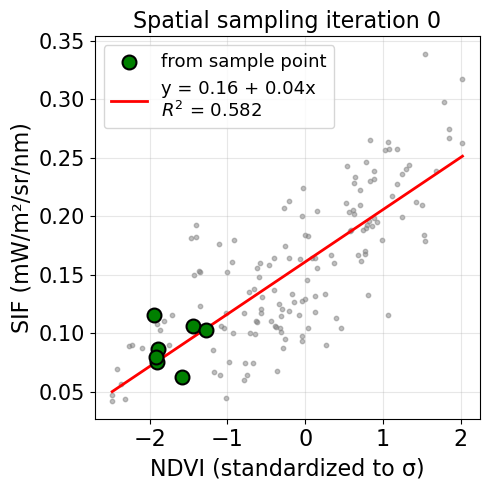

In [ ]:
# Fit multilinear regression model
iseed = 0
formula = f'SIF ~ {covariate_name}'
df_sampled = spatial_subsample_grid_probabilistic(df_standardized,
                                                        spacing_deg=min_dists[1],
                                                        seed=iseed)

model = smf.ols(formula, data=df_sampled)
result = model.fit()

# Plot scatter plot with regression line
plt.figure(figsize=(5, 5))
plt.scatter(df_sampled[covariate_name], df_sampled['SIF'], alpha=0.5, s=10, color='gray')

# Add points from sample location with larger green markers
plt.scatter(covariate_at_sample[covariate_name], sif_at_point.values, 
           s=100, color='green', edgecolors='black', linewidth=1.5, 
           zorder=5, label='from sample point')

# Add regression line
x_range = np.linspace(df_sampled[covariate_name].min(), df_sampled[covariate_name].max(), 100)
y_pred = result.params['Intercept'] + result.params[covariate_name] * x_range
plt.plot(x_range, y_pred, 'r-', linewidth=2, label=f'y = {result.params["Intercept"]:.2f} + {result.params[covariate_name]:.2f}x\n$R^2$ = {result.rsquared:.3f}')

plt.xlabel(f'{covariate_name} (standardized to σ)')
plt.ylabel('SIF (mW/m²/sr/nm)')
plt.title(f'Spatial sampling iteration {iseed}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Performing regression with stochastic sampling - results
For each regression analysis (i.e. SIF vs some variable) we will perform multiple iterations of pixel selection using the lengthscales we found from the previous workbook (spatial autocorrelation lengthscale notebook). We will then take the average slopes and the R$^2$ values from each model.
### NOTE:
We have 4 different versions of "annualized" values, corresponding to 4 different averaging methods:
- Full growing season (all snow-free values in a given year)
- Peak growing season (top 6 snow-free avlues in a given year)
- 'Green-up' (all snow-free values prior to peak LAI in a given year)
- 'Senescence' (all snow-free values after peak LAI in a given year)

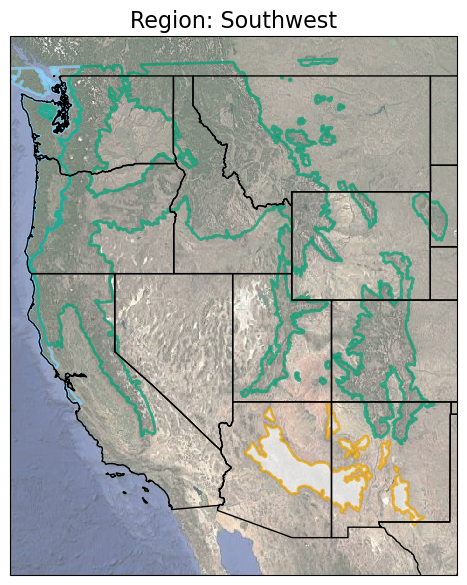

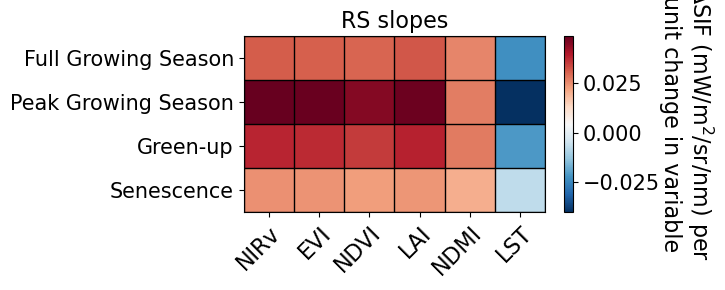

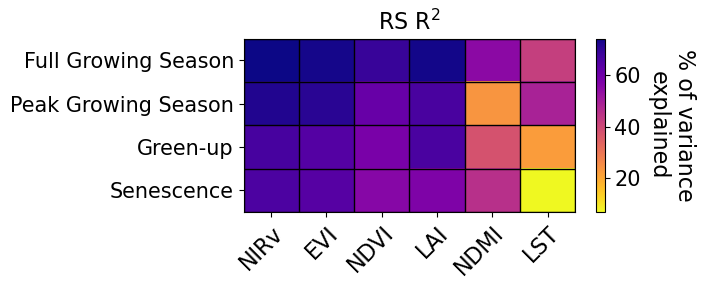

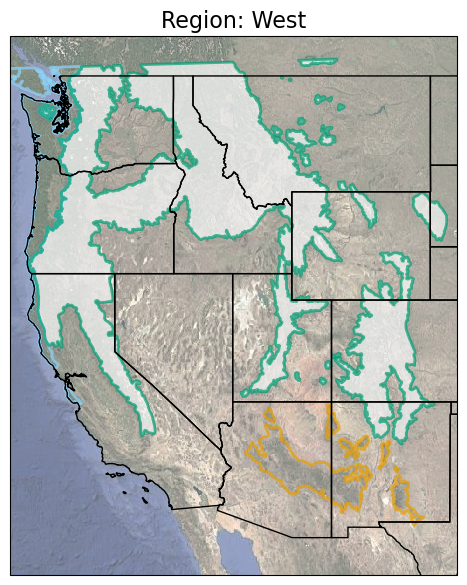

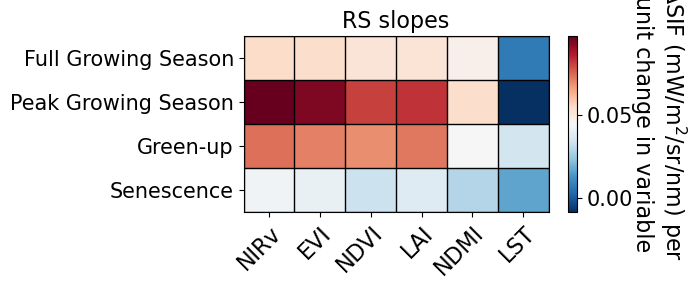

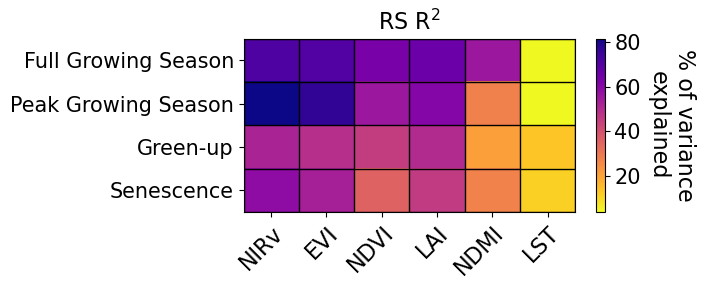

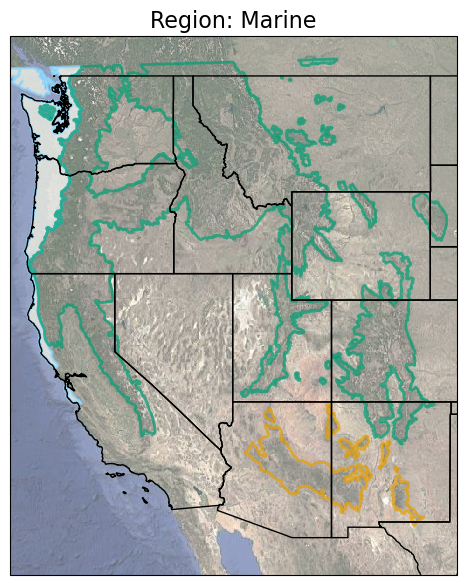

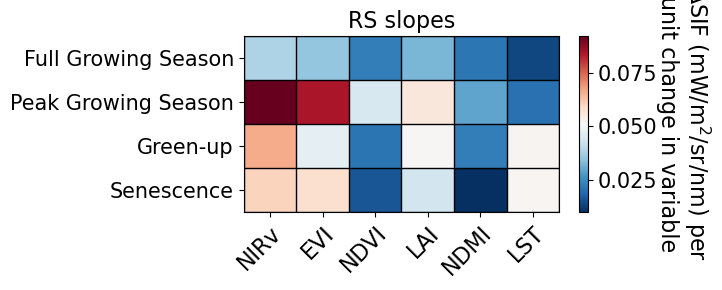

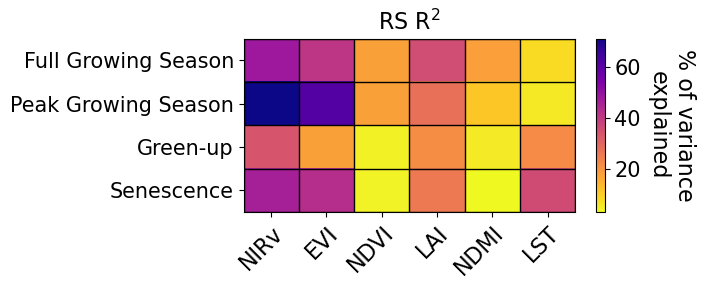

In [12]:
# Create an array of the xarray variables to test as covariates
covariates_descr = 'RS'
covariate_names = ['NIRv', 'EVI', 'NDVI', 'LAI', 'NDMI', 'LST']

timing_labels = ['FULL_YEAR', 'TOP_QUARTILE',  'PRE_PEAK_LAI','POST_PEAK_LAI']
timing_labels_descr = ['Full Growing Season', 'Peak Growing Season', 'Green-up', 'Senescence']

for ii, region_geom in enumerate(region_geoms):
    region_name = region_names[ii]
    plot_ecoregion_map(region_name, region_geom)


    # Create empty dataframes to store results across timing labels
    coeffs_df = pd.DataFrame(index=timing_labels, columns=covariate_names, dtype=float)
    r2_df = pd.DataFrame(index=timing_labels, columns=covariate_names, dtype=float)


    for jj, timing_label in enumerate(timing_labels):
        # print(f"\nModeling SIF with annual averaging method: {timing_label}")
        dat_dir = os.path.join(dat_basedir, timing_label)  # directory where data files are stored, based on timing_label

        ## Define paths to data files
        TROPOMI_SIF_file = glob.glob(f'{dat_dir}/TROPOMI_SIF*.nc')[0]
        MODIS_NDVI_file = glob.glob(f'{dat_dir}/MODIS_MOD13A2_NDVI*.nc')[0]
        MODIS_EVI_file = glob.glob(f'{dat_dir}/MODIS_MOD13A2_EVI*.nc')[0]
        MODIS_NDMI_file = glob.glob(f'{dat_dir}/MODIS_MCD43A4_NDMI*.nc')[0]
        MODIS_NIRv_file = glob.glob(f'{dat_dir}/MODIS_MCD43A4_NIRv*.nc')[0]
        MODIS_LAI_file = glob.glob(f'{dat_dir}/MODIS_MOD15A2H_LAI*.nc')[0]
        MODIS_LST_file = glob.glob(f'{dat_dir}/MODIS_MYD21A2_LST*.nc')[0]

        ###### Load all the files as xarray dataarrays
        # Remote sensing vegetation indices files
        TROPOMI_SIF_xr = load_xr(TROPOMI_SIF_file, 'sifdc') # TROPOMI SIF
        MODIS_NDVI_xr = load_xr(MODIS_NDVI_file, 'NDVI') # MODIS NDVI
        MODIS_EVI_xr = load_xr(MODIS_EVI_file, 'EVI') # MODIS EVI
        MODIS_NDMI_xr = load_xr(MODIS_NDMI_file, 'NDMI') # MODIS NDMI
        MODIS_NIRv_xr = load_xr(MODIS_NIRv_file, 'NIRv') # MODIS NIRv
        MODIS_LAI_xr = load_xr(MODIS_LAI_file, 'LAI') # MODIS LAI
        MODIS_LST_xr = load_xr(MODIS_LST_file, 'LST_Day') # MODIS LST
        covariate_xr_arr = [MODIS_NIRv_xr, MODIS_EVI_xr, MODIS_NDVI_xr, MODIS_LAI_xr, MODIS_NDMI_xr, MODIS_LST_xr]
        covariate_results = {}

        for covariate_xr, covariate_name in zip(covariate_xr_arr, covariate_names):
            model_results = {}
            xr_data_dict = {
                'SIF': TROPOMI_SIF_xr.rio.clip(region_geom.geometry, drop=True),
                covariate_name: covariate_xr.rio.clip(region_geom.geometry, drop=True),
            }

            df_long = xarray_to_long_df(xr_data_dict, 'SIF')
            key_vars = ['SIF', covariate_name]

            # Add pixel_id, longitude, latitude
            df_long['pixel_id'] = df_long['x'].astype(str) + '_' + df_long['y'].astype(str)
            df_long['longitude'] = df_long['x']
            df_long['latitude'] = df_long['y']

            # Clean up - remove rows with missing values in key variables
            df_model = df_long.dropna(subset=key_vars).copy()

            # Standardize predictors
            all_predictors = [covariate_name]
            df_standardized = df_model.copy()
            df_standardized[all_predictors] = StandardScaler().fit_transform(df_model[all_predictors])

            # Fit multilinear regression model
            formula = f'SIF ~ {covariate_name}'
            coeff_list = []
            r2_list = []
            for iseed in range(num_reps):
                df_sampled = spatial_subsample_grid_probabilistic(df_standardized,
                                                            spacing_deg=min_dists[ii],
                                                            seed=iseed)

                try:
                    model = smf.ols(formula, data=df_sampled)
                    result = model.fit()
                    model_results['full_result'] = result
                    coeff_list.append(result.params[covariate_name])
                    r2_list.append(result.rsquared)
                except Exception as e:
                    print(f"Model fitting failed: {e}")

            model_result_params = {}
            model_result_params['coeff'] = np.mean(coeff_list)
            model_result_params['coeff_sd'] = np.std(coeff_list)
            model_result_params['r2'] = np.mean(r2_list)
            model_result_params['r2_sd'] = np.std(r2_list)
            
            covariate_results[covariate_name] = model_result_params
                    
            # Assign to dataframes
            coeffs_df.loc[timing_label, covariate_name] = np.mean(coeff_list)
            r2_df.loc[timing_label, covariate_name] = np.mean(r2_list)

    #########################
    # Create heatmap of coefficients
    #########################
    fig, ax = plt.subplots(figsize=(7, 3))

    # Convert to numeric and create heatmap
    coeffs_numeric = coeffs_df.astype(float)
    im = ax.imshow(coeffs_numeric.values, cmap='RdBu_r', aspect='auto')

    # Set ticks and labels
    ax.set_xticks(np.arange(len(covariate_names)))
    ax.set_yticks(np.arange(len(timing_labels)))
    ax.set_xticklabels(covariate_names)
    ax.set_yticklabels(timing_labels_descr)

    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add grid lines to create borders around each cell
    ax.set_xticks(np.arange(len(covariate_names)+1)-.5, minor=True)
    ax.set_yticks(np.arange(len(timing_labels)+1)-.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", size=0)
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(r'ΔSIF (mW/m$^2$/sr/nm) '+ 'per\nunit change in variable', rotation=270, labelpad=40)
    ax.set_title(f'{covariates_descr} slopes')
    plt.tight_layout()
    plt.show()


    #########################
    # Create heatmap of R2
    #########################
    fig, ax = plt.subplots(figsize=(7, 3))

    # Convert to numeric and create heatmap
    r2_numeric = r2_df.astype(float) * 100  # convert to percentage
    im = ax.imshow(r2_numeric.values, cmap='plasma_r', aspect='auto')

    # Set ticks and labels
    ax.set_xticks(np.arange(len(covariate_names)))
    ax.set_yticks(np.arange(len(timing_labels)))
    ax.set_xticklabels(covariate_names)
    ax.set_yticklabels(timing_labels_descr)

    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add grid lines to create borders around each cell
    ax.set_xticks(np.arange(len(covariate_names)+1)-.5, minor=True)
    ax.set_yticks(np.arange(len(timing_labels)+1)-.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", size=0)
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('% of variance\nexplained', rotation=270, labelpad=40)
    ax.set_title(f'{covariates_descr} R$^2$')
    plt.tight_layout()
    plt.show()



